# **Project 2 - Time Series SARIMA Analysis**

!! **Note** - This notebook utilizes SARIMA models, which require analyzing extensive historical data. As a result, the modeling process may take a significant amount of time to complete. Please be aware that each run of the modeling section **may exceed 10 minutes** !!

This notebook performs an analysis of U.S. mortgage interest rates from 1990 to 2024, with a focus on predicting future trends using Seasonal Autoregressive Integrated Moving Average (SARIMA) models. The cleaned dataset includes interest rates for 30-year and 15-year fixed-rate mortgages (FRM) on a weekly basis. The analysis involves analyzing past FRM trends to forecast the next 10 years of mortgage rates and evaluating the model’s performance against actual mortgage rate data. The goal is to identify key trends, assess seasonal patterns, and forecast future rates based on historical data.

The main sections of this notebook are:

1. Preprocessing: Applied ACF/PACF plots and seasonal decomposition to determine the optimal parameters for the model.

2. Modeling and Visualizations: Implemented SARIMA to analyze historical mortgage rates and forecast future trends, accompanied by  visualizations to display results.

3. Statistical Significance: Compiled table to show performance metrics, MAE and RSME values, to assess accuracy of model.

## Section 1 - Preprocessing

In [1]:
# install python library
!pip install pmdarima

In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

In [3]:
# load cleaned data CSV
df = pd.read_csv("/content/cleaned_df.csv")
df = df.drop(columns=['Unnamed: 0']) # drop unnecessary column
df['Week'] = pd.to_datetime(df['Week']) # convert week to datetime format
df.set_index('Week', inplace=True) # set week as index
df

,U.S. 30 yr FRM,U.S. 15 yr FRM
Week,,
1991-08-30,9.15,8.77
1991-09-06,9.14,8.79
1991-09-13,9.02,8.68
1991-09-20,8.95,8.62
1991-09-27,8.92,8.59
...,...,...
2024-09-12,6.20,5.27
2024-09-19,6.09,5.15
2024-09-26,6.08,5.16


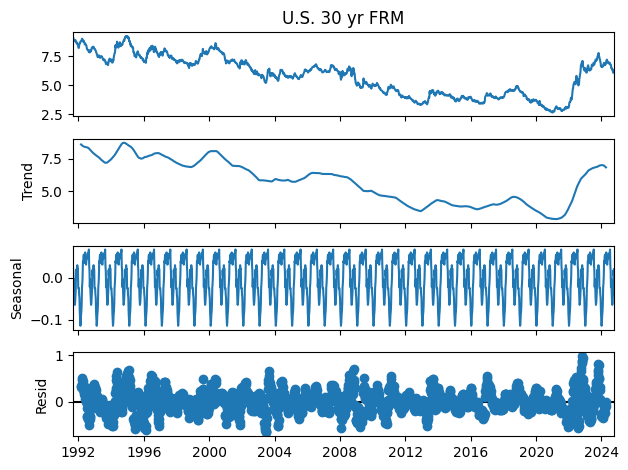

In [4]:
# apply seasonal decomposition to the 30-Year FRM data to determine if seasonal trends appear
decomposition = seasonal_decompose(df['U.S. 30 yr FRM'], model='additive', period=52)
decomposition.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

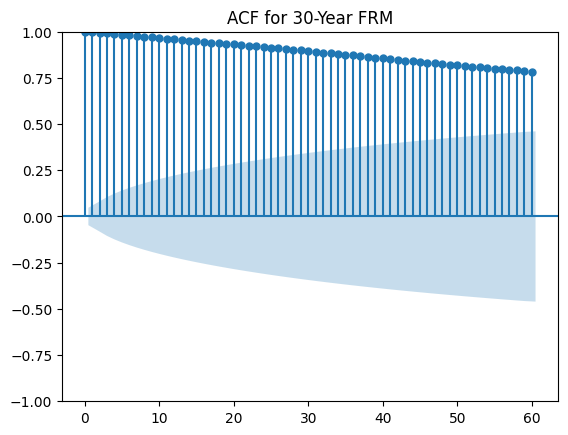

<Figure size 1200x600 with 0 Axes>

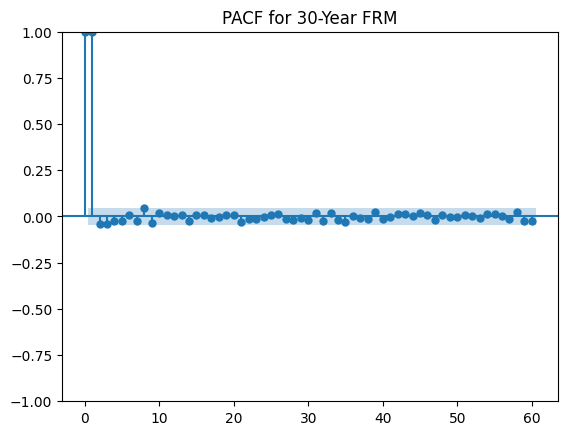

In [5]:
# plot ACF and PACF for 30-year FRM to manually determine p, d, q parameters
plt.figure(figsize=(12, 6))
plot_acf(df['U.S. 30 yr FRM'].dropna(), lags=60)
plt.title('ACF for 30-Year FRM')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['U.S. 30 yr FRM'].dropna(), lags=60)
plt.title('PACF for 30-Year FRM')
plt.show()

## Section 2 - Modeling and Visualizations

We run two types of SARIMA models in this section: one using auto SARIMA, which automatically selects the parameters, and another with manually chosen parameters. This allows us to compare the performance and identify which approach produces better results.

Attempt 1: Auto SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=-3050.291, Time=81.54 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-3032.108, Time=0.30 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-3037.482, Time=6.96 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-3036.182, Time=24.42 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-3033.649, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=-3051.776, Time=67.79 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=-3053.931, Time=3.87 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=-3051.944, Time=71.95 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=-3051.716, Time=1.82 sec
 ARIMA(2,1,1)(0,0,0)[52] intercept   : AIC=-3051.551, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[52] intercept   : AIC=-3050.601, Time=6.40 sec
 ARIMA(2,1,3)(0,0,0)[52] intercept   : AIC=-3049.293, Time=4.49 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=-3050.620, Time=1.43 sec
 ARIMA(1,1,3)(0,0,0)[52] intercept   : AIC=-3049.830, Time=3.43 sec
 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


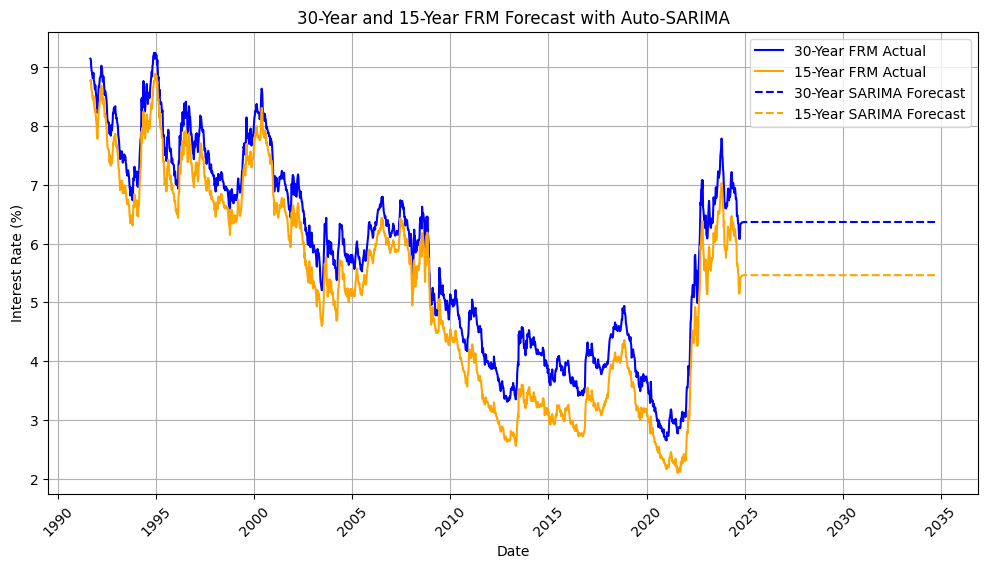

In [6]:
# plot forecast using auto SARIMA that systematically selects the most optimal p,d,q parameters

# run auto arima for both variables using seasonal parameter m=52 to capture yearly seasonality trends
sarima_30yr_model = auto_arima(df['U.S. 30 yr FRM'], seasonal=True, m=52, trace=True,
                               suppress_warnings=True, stepwise=True)
sarima_15yr_model = auto_arima(df['U.S. 15 yr FRM'], seasonal=True, m=52, trace=True,
                               suppress_warnings=True, stepwise=True)

# fit SARIMA models based on the optimal values found
sarima_30yr_fit = sarima_30yr_model.fit(df['U.S. 30 yr FRM'])
sarima_15yr_fit = sarima_15yr_model.fit(df['U.S. 15 yr FRM'])

# forecast for the next 10 years
forecast_steps = 52 * 10
forecast_30yr = sarima_30yr_fit.predict(n_periods=forecast_steps)
forecast_15yr = sarima_15yr_fit.predict(n_periods=forecast_steps)

# create a date range for the forecasted values to align with weekly data
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(weeks=1), periods=forecast_steps, freq='W-THU')

# plot auto SARIMA forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['U.S. 30 yr FRM'], label='30-Year FRM Actual', color='blue')
plt.plot(df.index, df['U.S. 15 yr FRM'], label='15-Year FRM Actual', color='orange')
plt.plot(forecast_index, forecast_30yr, label='30-Year SARIMA Forecast', color='blue', linestyle='--')
plt.plot(forecast_index, forecast_15yr, label='15-Year SARIMA Forecast', color='orange', linestyle='--')
plt.title('30-Year and 15-Year FRM Forecast with Auto-SARIMA')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Attempt 2: Manual SARIMA

ADF Test for 30-Year FRM:
ADF Statistic: -2.076566618289558
p-value: 0.25404106658470255
Data is not stationary, consider differencing

ADF Test for 15-Year FRM:
ADF Statistic: -2.040972524289311
p-value: 0.26890190419436855
Data is not stationary, consider differencing


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


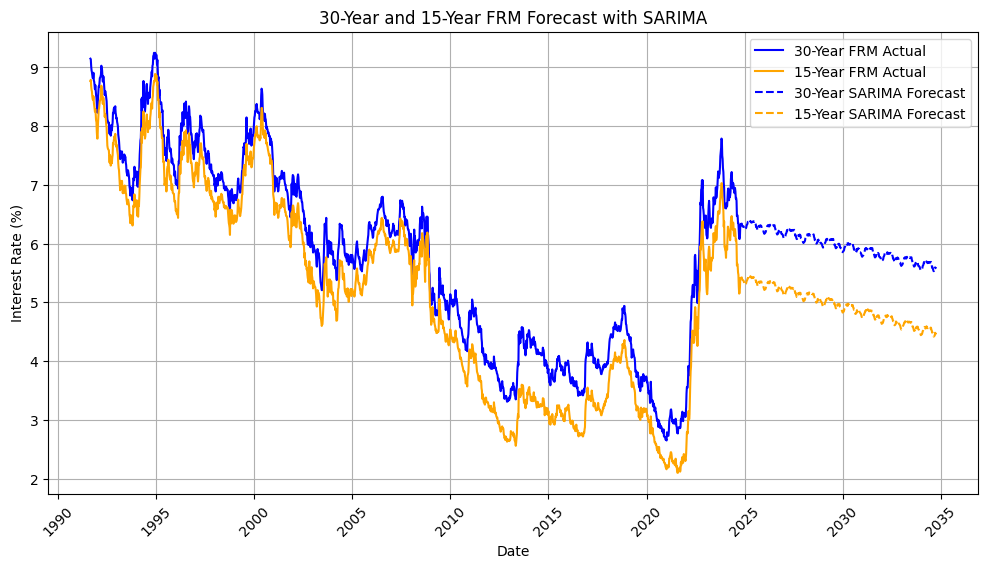

In [7]:
# plot forecast using manually determined parameters

# manually set ARIMA and SARIMA parameters based on ACF and PACF plots
# 30-Year FRM: p=2, d=1, q=1 | P=1, D=1, Q=1, m=52
# 15-Year FRM: p=2, d=1, q=1 | P=1, D=1, Q=1, m=52

# function to do ADF test for stationarity
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is not stationary, consider differencing")

# check stationarity for both 30-year and 15-year FRM
print("ADF Test for 30-Year FRM:")
adf_test(df['U.S. 30 yr FRM'])
print("\nADF Test for 15-Year FRM:")
adf_test(df['U.S. 15 yr FRM'])

# fit ARIMA model to 30-Year FRM data
arima_30yr_model = ARIMA(df['U.S. 30 yr FRM'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_30yr_fit = arima_30yr_model.fit()

# fit ARIMA model to 15-Year FRM data
arima_15yr_model = ARIMA(df['U.S. 15 yr FRM'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_15yr_fit = arima_15yr_model.fit()

# forecast for the next 10 years
forecast_steps = 52 * 10  # 10 years of weekly data
forecast_30yr = arima_30yr_fit.predict(start=len(df), end=len(df) + forecast_steps - 1)
forecast_15yr = arima_15yr_fit.predict(start=len(df), end=len(df) + forecast_steps - 1)

# create a date range for the forecasted values to align with weekly data
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(weeks=1), periods=forecast_steps, freq='W-THU')

# plot SARIMA forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['U.S. 30 yr FRM'], label='30-Year FRM Actual', color='blue')
plt.plot(df.index, df['U.S. 15 yr FRM'], label='15-Year FRM Actual', color='orange')
plt.plot(forecast_index, forecast_30yr, label='30-Year SARIMA Forecast', color='blue', linestyle='--')
plt.plot(forecast_index, forecast_15yr, label='15-Year SARIMA Forecast', color='orange', linestyle='--')
plt.title('30-Year and 15-Year FRM Forecast with SARIMA')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Model Performance Check

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

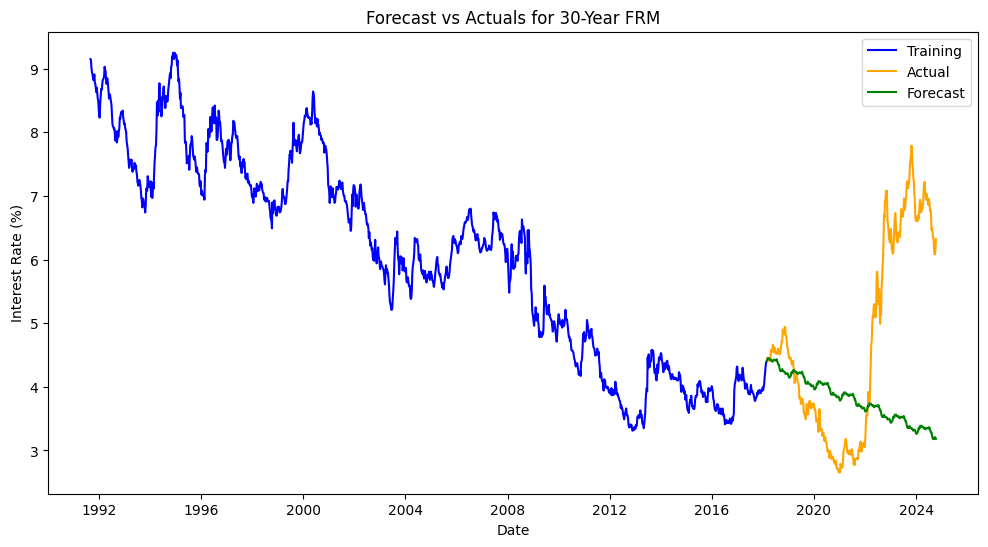

In [8]:
# check accuracy of our SARIMA model by comparing forecasted values with actual data

# split the data into train and test sets
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train_data, test_data = df[:train_size], df[train_size:]

# manual SARIMA for 30-Year FRM
sarima_30yr_model = ARIMA(train_data['U.S. 30 yr FRM'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 52))
sarima_30yr_fit = sarima_30yr_model.fit()

# forecast for the test set period
forecast_30yr = sarima_30yr_fit.predict(start=len(train_data), end=len(df) - 1)

# plot historical, forecasted and actual data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['U.S. 30 yr FRM'], label='Training', color='blue')
plt.plot(test_data.index, test_data['U.S. 30 yr FRM'], label='Actual', color='orange')
plt.plot(test_data.index, forecast_30yr, label='Forecast', color='green')
plt.title('Forecast vs Actuals for 30-Year FRM')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.legend()
plt.show()

## Section 3 - Statistical Significance

In [9]:
# calculate MAE and RMSE
mae = mean_absolute_error(test_data['U.S. 30 yr FRM'], forecast_30yr)
rmse = np.sqrt(mean_squared_error(test_data['U.S. 30 yr FRM'], forecast_30yr))

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Absolute Error (MAE): 1.512
Root Mean Squared Error (RMSE): 2.009
